# MBHB Astrometric Calculator
A simple notebook to exercise the MBHB waveform code to compute SNR, SNR vs. time, and resolution vs. time

To run this on Google Colab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnGBaker/GWI-metrics/blob/main/Notebooks/binaryResolution.ipynb)

### Some basic setup

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/JohnGBaker/GWI-metrics.git
    src='GWI-metrics/src/'
else:
    src='../src/'
    
# Import
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src/')
import constants
import metrics
import sources
import concepts
import subsystems
import background

### Define the source
Here we load in one of the pre-defined sources. Or you can define your own

In [15]:
sourceName = 'MBHB73'
source = eval('sources.%s' % sourceName).copy()
source

{'type': 'chirp',
 'label': '$10^{7}\\,M_{\\odot}+10^{7}\\,M_{\\odot}\\:@\\:z=3$',
 'm1': 10000000.0,
 'm2': 10000000.0,
 'dl': 25924000.0}

### Define the concepts
Here we load in some pre-defined mission concepts

In [16]:
# list of concepts by name
conceptNames = (
    'LISACBE',
    'LISASciRDv1',
    'TwinLISA',
    'LISAGrande',
    'LISAU',
    'GoBIGLISA')

models = list()
for c in conceptNames:
    model = eval('concepts.%s' % c)         # load the concept
    model = background.add2model(model)     # add galactic background model
    models.append(model)                    # add model to list
    

### Perform the observations
We first compute the SNR and then the angular resolution

In [17]:
obs = list()
for m in models:
    ob = metrics.getSourceSnr(source,m,-4.0*constants.year)
    ob = metrics.getResolution(ob)
    obs.append(ob)
    

### Make some plots

#### Plot sensitivity curves and waveform
Here we scale the waveform by delta-f, which is probably not quite right

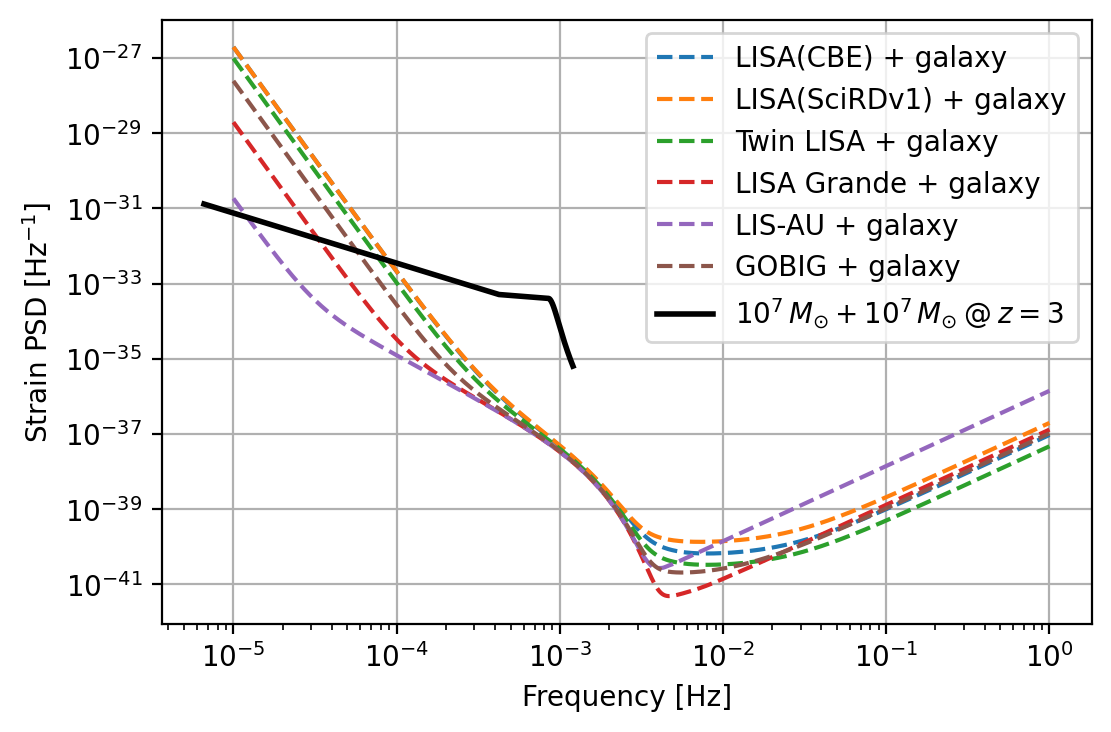

In [18]:
# sensitivity plot
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
f = np.logspace(-5,0,1000)
for ob in obs:
    ax.plot(f,metrics.makeSensitivity(f,ob.get('model')),linestyle='--',label=ob.get('model').get('label'))
    
ax.plot(ob.get('f')[1:],np.abs(ob.get('h')[1:]**2)*np.diff(ob.get('f')),'none',color='black',linestyle='-',linewidth = 2.0,label=ob.get('source').get('label'))

ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Strain PSD [Hz$^{-1}$]')
plt.legend()
ax.grid(True)
plt.savefig('../plots/%s_sensitivities.png' % sourceName)

#### SNR as a function of time plot

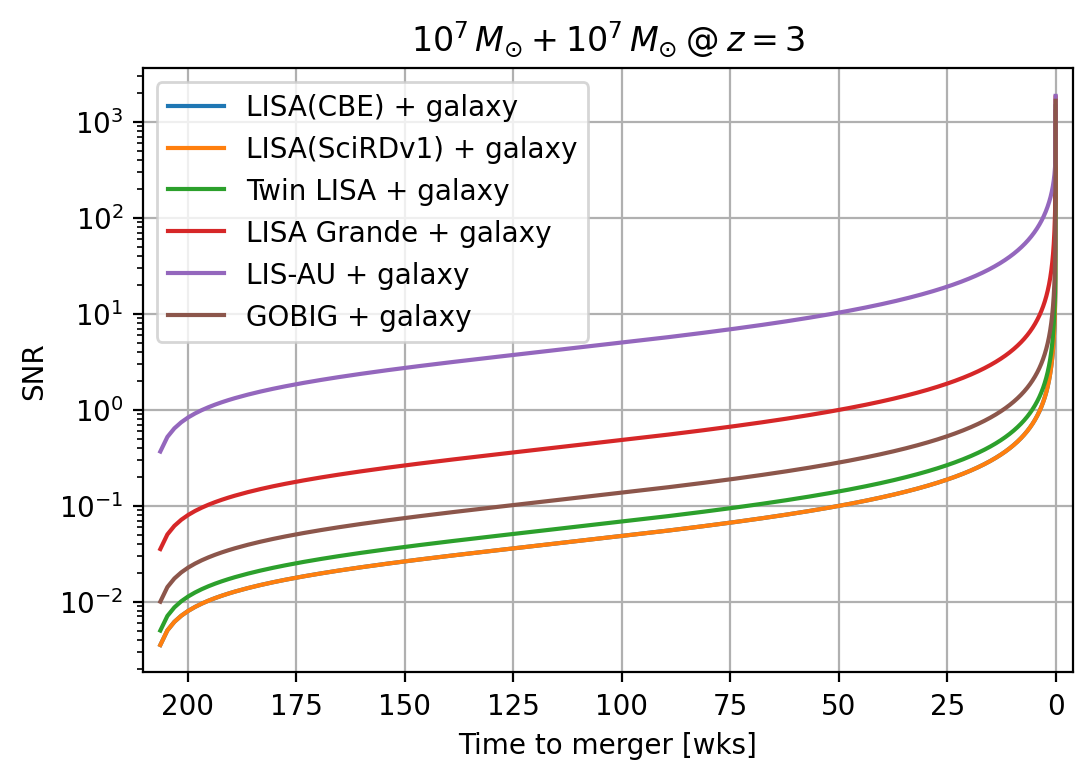

In [19]:
# SNR of time plot
fig = plt.figure(figsize=(6,4),dpi=200)
ax = fig.add_subplot(1,1,1)
for ob in obs:
    ax.plot(-ob.get('t')*52/constants.year,ob.get('SNR of t'),linestyle='-',label=ob.get('model').get('label'))

plt.xlim([-ob.get('t')[0]*52/constants.year+4,-4])
plt.title(ob.get('source').get('label'))
ax.set_xscale('linear')
ax.set_yscale('log')
plt.xlabel('Time to merger [wks]')
plt.ylabel(r'SNR')
plt.legend()
ax.grid(True)
plt.savefig('../plots/%s_snr_v_t.png' % sourceName)

#### Angular resolution as a function of time

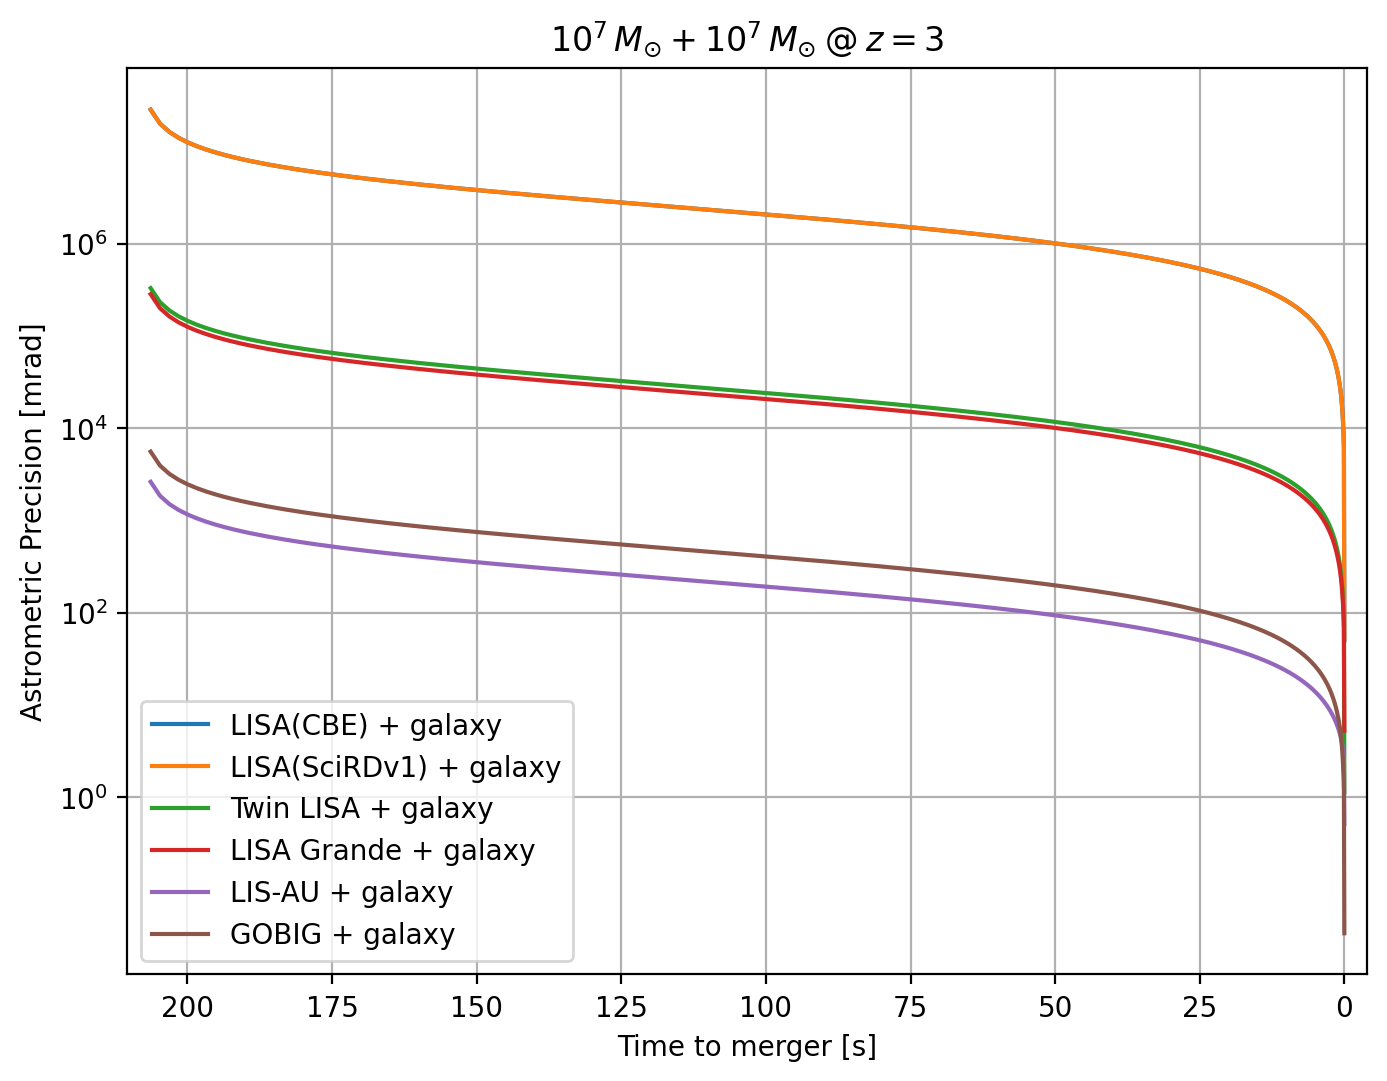

In [20]:
# Angular resolution
fig = plt.figure(figsize=[8,6],dpi=200)
ax = fig.add_subplot(1,1,1)
for ob in obs:
    ax.plot(-ob.get('t')*52/constants.year,ob.get('Angular Resolution')*1e3,label= ob.get('model').get('label'))
plt.xlim([-ob.get('t')[0]*52/constants.year+4,-4])
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.xlabel('Time to merger [s]')
plt.ylabel('Astrometric Precision [mrad]')
plt.title(ob.get('source').get('label'))
plt.savefig('../plots/%s_res_v_t.png' % sourceName)

### Make a table of the results

In [21]:
import pandas as pd

In [22]:
t_table = 0 # time before merger for generating table
t = obs[0].get('t')
i_table = np.clip(np.argmin(np.abs(t-t_table)),0,np.size(t)-1)
names = list()
SNRs = list()
res = list()
obtimes = list()
for ob in obs:
    names.append(ob.get('model').get('label'))
    SNRs.append(ob.get('SNR of t')[i_table])
    res.append(ob.get('Angular Resolution')[i_table]/1e-3)
    obtimes.append(-(ob.get('observation time')-t_table)*365/constants.year)

df = pd.DataFrame(index = names, data = {
    'SNR' : SNRs,
    'Angular Resolution [mrad]' : res,
    'Observation Time [days]' : obtimes
})

df['Angular Resolution [arcsec]']= df['Angular Resolution [mrad]']*1e-3*180/np.pi*3600
df[['SNR', 'Observation Time [days]', 'Angular Resolution [mrad]', 'Angular Resolution [arcsec]']]
    

,SNR,Observation Time [days],Angular Resolution [mrad],Angular Resolution [arcsec]
LISA(CBE) + galaxy,1286.811073,1.287424,50.040489,10321.591779
LISA(SciRDv1) + galaxy,1257.842091,1.277278,51.192956,10559.305252
Twin LISA + galaxy,1451.274048,2.119295,1.134368,233.980282
LISA Grande + galaxy,1800.502267,25.016875,5.270079,1087.031753
LIS-AU + galaxy,1864.430786,359.894669,0.513800,105.978790
GOBIG + galaxy,1658.171125,5.306046,0.033610,6.932538
